# Linear Regression

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# 1. Data preprocessing
- I'll use the bike sharing dataset from UCI Machine Learning Repository.
- The dataset contains the hourly count of rental bikes between years 2017 and 2018 in the Capital Bikeshare system with the corresponding weather and seasonal information.
- First I should convert the data to a usable format, like change the holiday and functioning day  and holiday to 0 and 1
- Also I should convert the season and month to one-hot encoding, then I can use the data to train the model.

In [172]:
file_path = './SeoulBikeData.csv'
bike_data = pd.read_csv(file_path)

# Convert 'Date' to datetime and extract year and month as new features
bike_data['Date'] = pd.to_datetime(bike_data['Date'], format='%d/%m/%Y')
bike_data['Year'] = bike_data['Date'].dt.year
bike_data['Month'] = bike_data['Date'].dt.month

# Drop the 'Date' column as we've extracted usable numerical features
bike_data = bike_data.drop(['Date'], axis=1)

# Perform label encoding on 'Seasons', 'Holiday', and 'Functioning Day'
# Here, I used a simple mapping since these are binary or ordinal categories
holiday_mapping = {'No Holiday': 0, 'Holiday': 1}
functioning_day_mapping = {'Yes': 1, 'No': 0}
seasons_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
bool_mapping = {True: 1, False: 0}

bike_data['Holiday'] = bike_data['Holiday'].map(holiday_mapping)
bike_data['Functioning Day'] = bike_data['Functioning Day'].map(functioning_day_mapping)

# Perform one-hot encoding on 'Seasons', 'Month', and 'Year'
bike_data = pd.get_dummies(bike_data, columns=['Seasons', 'Month', 'Year'], drop_first=False)

bike_data['Seasons_Autumn'] = bike_data['Seasons_Autumn'].map(bool_mapping)
bike_data['Seasons_Spring'] = bike_data['Seasons_Spring'].map(bool_mapping)
bike_data['Seasons_Summer'] = bike_data['Seasons_Summer'].map(bool_mapping)
bike_data['Seasons_Winter'] = bike_data['Seasons_Winter'].map(bool_mapping)

bike_data['Month_1'] = bike_data['Month_1'].map(bool_mapping)
bike_data['Month_2'] = bike_data['Month_2'].map(bool_mapping)
bike_data['Month_3'] = bike_data['Month_3'].map(bool_mapping)
bike_data['Month_4'] = bike_data['Month_4'].map(bool_mapping)
bike_data['Month_5'] = bike_data['Month_5'].map(bool_mapping)
bike_data['Month_6'] = bike_data['Month_6'].map(bool_mapping)
bike_data['Month_7'] = bike_data['Month_7'].map(bool_mapping)
bike_data['Month_8'] = bike_data['Month_8'].map(bool_mapping)
bike_data['Month_9'] = bike_data['Month_9'].map(bool_mapping)
bike_data['Month_10'] = bike_data['Month_10'].map(bool_mapping)
bike_data['Month_11'] = bike_data['Month_11'].map(bool_mapping)
bike_data['Month_12'] = bike_data['Month_12'].map(bool_mapping)

bike_data['Year_2017'] = bike_data['Year_2017'].map(bool_mapping)
bike_data['Year_2018'] = bike_data['Year_2018'].map(bool_mapping)

# 2. Data Scaled
- I need scale the data before training the model. I'll use the min-max scaler to scale the data.

In [173]:
# We will standardize all the features except 'Rented Bike Count'
features_to_standardize = ['Hour', 'Temperature(?C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)','Dew point temperature(?C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

# Standardize the features
for feature in features_to_standardize:
    mean = bike_data[feature].mean()
    std = bike_data[feature].std()
    bike_data[feature] = (bike_data[feature] - mean) / std

# 3. Data Visualization
- I'll visualize the data to get a better understanding of the data.
- I used the scatter plot to visualize the relationship between the features and the label.

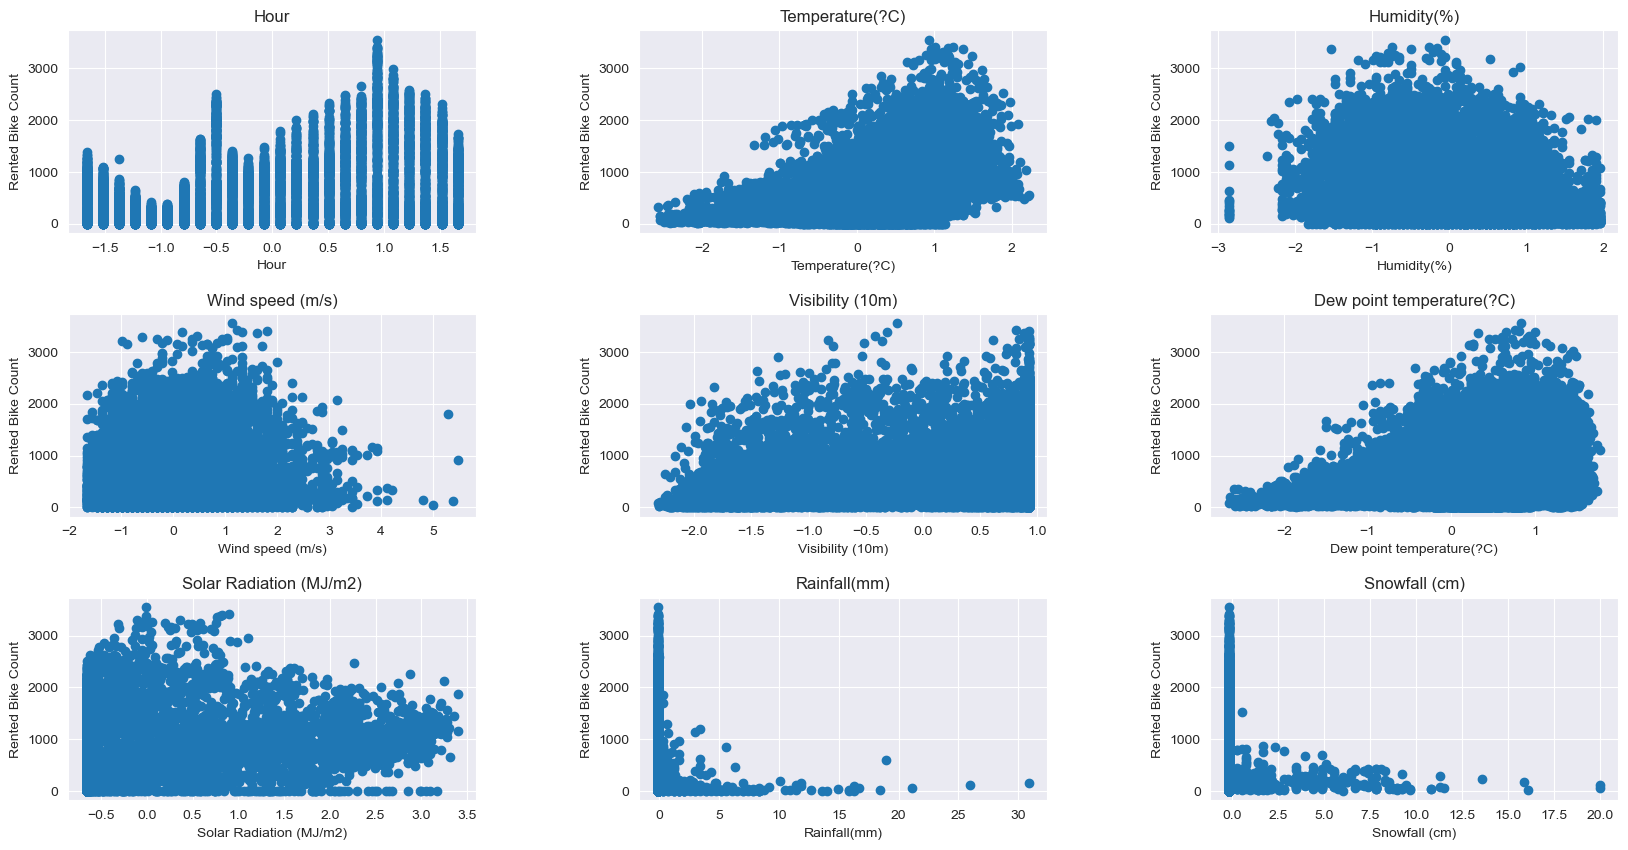

In [174]:
bike_data_labels = ['Hour', 'Temperature(?C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)','Dew point temperature(?C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.ravel()):
    if i < len(bike_data_labels):
        feature = bike_data_labels[i]
        ax.scatter(bike_data[feature], bike_data['Rented Bike Count'])
        ax.set_title(feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Rented Bike Count')
    else:
        ax.axis('off')
plt.show()

In [175]:
# sns.pairplot(bike_data, x_vars=bike_data_labels, y_vars=['Rented Bike Count'], height=5, aspect=1, kind='reg')

In [176]:
# bike_data = bike_data.drop(["Month_1", "Month_2", "Month_3", 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Holiday', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Functioning Day', 'Hour', 'Wind speed (m/s)', 'Visibility (10m)', 'Year_2017', 'Year_2018'], axis=1)
# bike_data.head()

# 4. Linear Regression
- In the class - LinearRegression, I'll implement the fit and predict methods.
- The fit method will train the model using gradient descent.

In [177]:
class LinearRegression:
    """
    Linear Regression class.
    :param learning_rate: The step length that will be taken when following the negative gradient during training.
    :param iterations: The number of iterations to train the model.
    :param w: The weights of the model.
    :param b: The bias of the model.
    :param cost_history: The cost history of the model which will be used to plot the cost over iterations.
    :param loss_history: The loss history of the model to track the performance over iterations.
    """

    def __init__(self, learning_rate, iterations):
        """
        Initializes the LinearRegression model with specified learning rate and number of iterations.
        :param learning_rate: The learning rate for the model.
        :param iterations: The number of iterations for which the model will be trained.
        """
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.w = None
        self.b = None
        self.cost_history = []
        self.loss_history = []

    def _initialize_weights(self, n_features):
        """
        Initializes weights and bias to zeros.
        :param n_features: The number of features in the dataset.
        """
        self.w = np.zeros(n_features)
        self.b = 0

    def _compute_cost(self, predictions, y):
        """
        Computes the cost (mean squared error) between the predictions and the true values.
        :param predictions: The predicted values from the model.
        :param y: The actual target values.
        :return: The computed mean squared error.
        """
        cost = np.mean((predictions - y) ** 2) / 2
        return cost

    def _compute_loss(self, predictions, y):
        """
        Computes the loss (squared error) for a single sample.
        :param predictions: The predicted value for the sample.
        :param y: The actual target value for the sample.
        :return: The computed squared error for the sample.
        """
        loss = (predictions - y) ** 2
        return loss

    def _compute_gradients(self, X, y, predictions):
        """
        Computes the gradients of the cost function with respect to the model parameters.
        :param X: The input features.
        :param y: The actual target values.
        :param predictions: The predicted values from the model.
        :return: The gradients with respect to weights and bias.
        """
        n_samples = len(y)
        dw = np.dot(X.T, (predictions - y)) / n_samples
        db = np.sum(predictions - y) / n_samples
        return dw, db

    def _update_parameters(self, dw, db):
        """
        Updates the model parameters using the computed gradients.
        :param dw: The gradient with respect to weights.
        :param db: The gradient with respect to bias.
        """
        self.w -= self.learning_rate * dw
        self.b -= self.learning_rate * db

    def fit(self, X, y):
        """
        Trains the Linear Regression model using gradient descent.
        :param X: The input features for training.
        :param y: The target values for training.
        """
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self._initialize_weights(n_features)

        # Gradient Descent
        for i in range(self.iterations):
            # Predictions
            predictions = self.predict(X)

            # Compute the cost and loss
            cost = self._compute_cost(predictions, y)
            loss = self._compute_loss(predictions, y)
            self.cost_history.append(cost)
            self.loss_history.append(loss)

            # Compute gradients
            dw, db = self._compute_gradients(X, y, predictions)

            # Update weights and bias
            self._update_parameters(dw, db)
            
        print(f"Final loss: {loss:.4f}")
        print(f"Final cost: {cost:.4f}")
        print(f"Final weights: {self.w}")
        print(f"Final bias: {self.b}")
        return self

    def predict(self, X):
        """
        Makes predictions using the linear model.
        :param X: The input features for making predictions.
        :return: The predicted values.
        """
        return np.dot(X, self.w) + self.b


# 5. Train the model
- Now that I have implemented the LinearRegression class, I can train the model.
- I'll use 80% of the data for training and 20% for testing.
- Due the linear regression is regression but my data set is classification, so I need round the predictions to the nearest integer to simulate classification.

## 5.1 Classify the data

In [178]:
# Shuffle the data
bike_data = bike_data.sample(frac=1, random_state=42)

# Split the data
X = bike_data.drop('Rented Bike Count', axis=1).values
y = bike_data['Rented Bike Count'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5.2 Train the model

In [179]:
linear_regression_model = LinearRegression(0.001, 50000)
linear_regression_model.fit(X_train, y_train)

predictions = linear_regression_model.predict(X_test)

Final loss: 176769.0079
Final cost: 88384.5039
Final weights: [ 191.12198254  235.93075671 -199.51908702   25.77130926   35.2363702
  125.36184329  -75.0035559   -76.3784158    18.51631069 -119.16158081
  686.97558381  109.6744953    31.93847802    3.02819928 -117.2986745
  -51.79484011  -85.11860074  -77.6978659   -16.78891058  126.42525451
  302.21832637  -57.2234247  -241.96670238  -28.00814275  114.42169474
   23.2609433    19.61476635   19.61476635    7.72773176]
Final bias: 27.342498106987065


# 6. Evaluate the model
## 6.1 Calculate the mse of the model
MSE (Mean Squared Error) is calculated as follows:
$$
\[ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( (y_i - \hat{y}_i)^2 \)$ is the square of the difference between the actual and predicted values.


In [180]:
def mse(y_true, y_pred):
    """
    The mse function is used to compute the mse of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the mse of the model
    """
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

print(f"MSE: {mse(y_test, predictions):.2f}")

MSE: 157399.09


## 6.2 Calculate the rmse of the model
RMSE (Root Mean Squared Error) is calculated as follows:
$$
\[ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( (y_i - \hat{y}_i)^2 \)$ is the square of the difference between the actual and predicted values.

In [181]:
def rmse(y_true, y_pred):
    """
    The rmse function is used to compute the rmse of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the rmse of the model
    """
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / len(y_true))

print(f"RMSE: {rmse(y_test, predictions):.2f}")

RMSE: 396.74


## 6.3 Calculate the r2 score of the model

R2 score (coefficient of determination) is calculated as follows:
$$
\[ \text{R2} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( \bar{y} \)$ is the mean of the actual values.
- $\( (y_i - \hat{y}_i)^2 \)$ is the square of the difference between the actual and predicted values.
- $\( (y_i - \bar{y})^2 \)$ is the square of the difference between the actual values and the mean of the actual values.

In [182]:
def r2_score(y_true, y_pred):
    """
    The r2_score function is used to compute the r2 score of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the r2 score of the model
    """
    mean = np.mean(y_true)
    ss_tot = np.sum((y_true - mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

print(f"R2 Score: {r2_score(y_test, predictions):.2f}")

R2 Score: 0.60


## 6.4 Calculate the mae of the model
MAE (Mean Absolute Error) is calculated as follows:
$$
\[ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| \]
$$
Where:

- $\( n \)$ is the number of samples.
- $\( y_i \)$ is the actual value.
- $\( \hat{y}_i \)$ is the predicted value.
- $\( |y_i - \hat{y}_i| \)$ is the absolute value of the difference between the actual and predicted values.
- $\( \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| \)$ is the mean of the absolute values of the difference between the actual and predicted values.

In [183]:
def mae(y_true, y_pred):
    """
    The mae function is used to compute the mae of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the mae of the model
    """
    return np.sum(np.abs(y_true - y_pred)) / len(y_true)

print(f"MAE: {mae(y_test, predictions):.2f}")

MAE: 297.61


## 6.5 Visualize the cost history

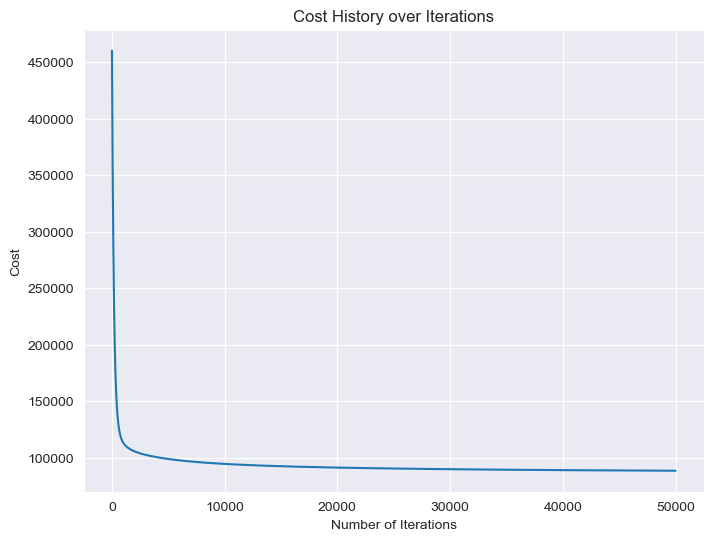

In [184]:
cost_history = linear_regression_model.cost_history
plt.figure(figsize=(8, 6))
plt.plot(cost_history)
plt.title('Cost History over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.show()

## 6.6 Visualize the loss history

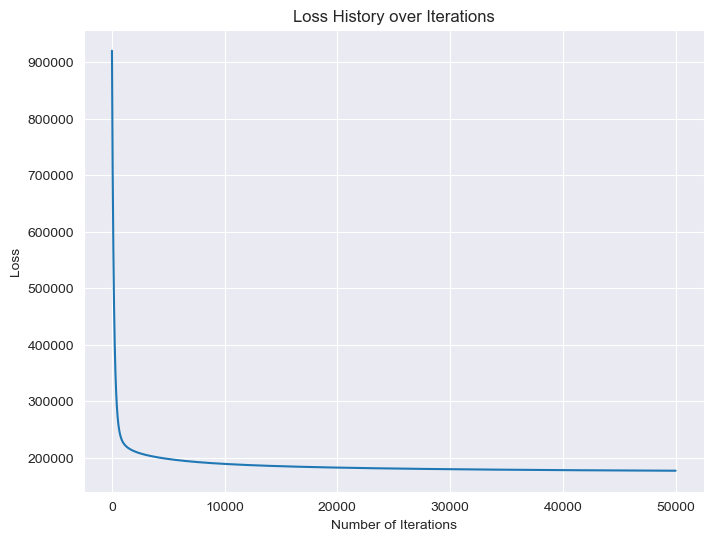

In [185]:
loss_history = linear_regression_model.loss_history
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.title('Loss History over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.show()